In [125]:
# The below cell contains code from Maarten which calculates the propagation time between two points

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

   /**
     * Get velocity of sound at given depth relative to seabed.
     *
     * \param  z              depth [m]
     * \return                velocity [m/s]
     */
    virtual double operator()(const double z) const override
    {
      return a + b * z;
    }


    /**
     * Get propagation time of sound.
     *
     * The propagation time is obtained from the integral \f$\Delta T = \frac{D}{\Delta z} \int\frac{1}{V(z)}dz\f$.\n
     * Note that the depth is relative to the seabed.
     *
     * \param  D_m            distance [m]
     * \param  z1             depth [m]
     * \param  z2             depth [m]
     * \return                time  [s]
     */
    virtual double getTime(const double D_m,
                           const double z1,
                           const double z2) const override
    {
      const double eps = 1.0e-8;

      const double ct  = (z2 - z1) / D_m;
      const double v1  = (*this)(z1);
      const double v2  = (*this)(z2);

      if (fabs(ct) > eps)
        return fabs(log(v2/v1) / (ct*b));
      else
        return 2.0 * D_m / (v1 + v2);
    }


# Maarten Code

In [3]:
class SoundVelocity:
    def __init__(self, a, b, c):
        self.a = a
        self.b = b
        self.c = c
    
    def __call__(self, z):
        return self.a + self.b * (z - self.c)
    
    def getTime(self, D_m, z1, z2):
        eps = 1.0e-8

        ct = (z2 - z1) / D_m
        v1 = self(z1)
        v2 = self(z2)

        if abs(ct) > eps:
            return abs(math.log(v2/v1) / (ct * self.b))
        else:
            return 2.0 * D_m / (v1 + v2)

In [4]:
# load data
data = np.loadtxt('TANGANYIKA_arrival_time_Bellhop_travel_distance.txt', skiprows=1)

distance_sea_floor = data[:, 0] 
height_DOM = data[:, 1]
arrival_time = data[:, 2]
angle_of_departure = data[:, 3]
angle_of_arrival = data[:, 4]

print(len(arrival_time))

1932


# Try to find a fitting ssp

In [16]:
# 1541.25 -17e-3 -2000.00

# original ssp constants
a = 1541.00
b = -17e-3
c = 2000.00
z0 = 3453.629

# calculate the sound velocity
sound_velocity = SoundVelocity(a, b, c)

In [63]:
distance = np.linspace(50, 10000, 200)
elevation = np.linspace(0, 1000, 11)

In [64]:
# initialise an empty list to append values to
propagation_time = []
distance_sea_floor = []
height_DOM = []

# loop through the values to find the propagation time
for i in range(len(distance)):
    for j in range(len(elevation)):
        dis = distance[i]
        el = elevation[j]
        
        if el == 0:
            el = 3
       
        if dis == 0:
            dis = 13

        # redefine some parameters
        z1 = z0 - el
        z2 = z0 - 3

        D_m = (dis**2 + (z2 - z1)**2)**(1/2)
        time = sound_velocity.getTime(D_m, z1, z2)

        propagation_time.append(time)
        distance_sea_floor.append(dis)
        height_DOM.append(el)

In [65]:
# check the distances
print(len(propagation_time))
print(len(distance_sea_floor1))
print(len(height_DOM1))

2200
1932
1932


In [66]:
delta_t = propagation_time - arrival_time

# set colorbar values
min = np.min(delta_t)
max = np.max(delta_t)

print(min)
print()

ValueError: operands could not be broadcast together with shapes (2200,) (1932,) 

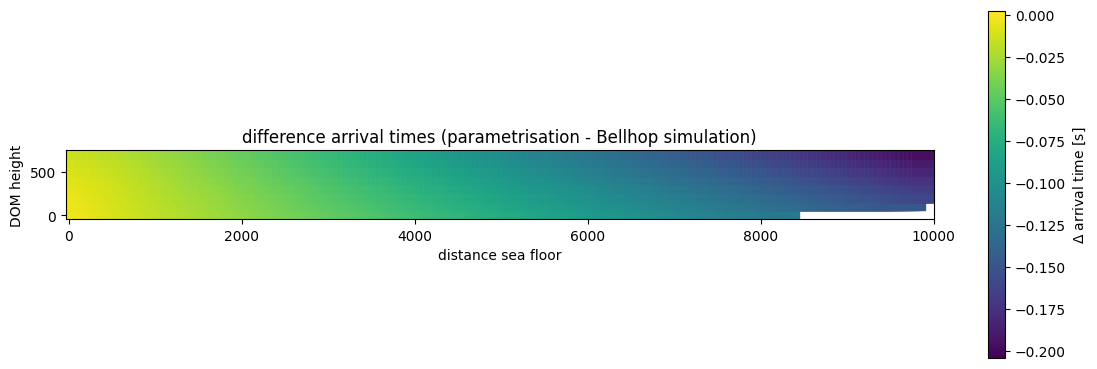

In [55]:
# Create a scatter plot with square markers
# Calculate the difference between consecutive values in x and y directions
dx = np.diff(distance_sea_floor).min()
dy = np.diff(height_DOM).min()

# Create a scatter plot with square markers
plt.figure(figsize=(14, 4.5))
plt.scatter(distance_sea_floor, height_DOM, c=delta_t, cmap='viridis', s=940, marker='s', alpha=1)#, vmin=0, vmax=max)
plt.colorbar(label='$\Delta$ arrival time [s]')
plt.xlabel('distance sea floor')
plt.ylabel('DOM height')
plt.xlim(-40, 10000)
plt.ylim(-45, 750)
plt.title('difference arrival times (parametrisation - Bellhop simulation)')
plt.gca().set_aspect('equal', adjustable='box') 

# Optimalisation

In [149]:
try_a = np.linspace(1450, 1600, 151)
try_b = np.linspace(-10e-3, -25e-3, 21)
try_c = np.linspace(1500, 2500, 21)

In [150]:
best_a = 0
best_b = 0
best_c = 0

best_difference = 1e6

for X in range(0, len(try_a)):
    for Y in range(0, len(try_b)):
        for Z in range(0, len(try_c)):
            a = try_a[X]
            b = try_b[Y]
            c = try_c[Z]

            # calculate the sound velocity
            sound_velocity = SoundVelocity(a, b, c)

            # initialise an empty list to append values to
            propagation_time = []

            # loop through the values to find the propagation time
            for i in range(len(distance_sea_floor)):
                dis = distance_sea_floor[i]
                el = height_DOM[i]
                
                if el == 0:
                    el = 3
            
                if dis == 0:
                    dis = 13
                
                # redefine some parameters
                z1 = z2 - el
                D_m = (dis**2 + (z2 - z1)**2)**(1/2)
                time = sound_velocity.getTime(D_m, z1, z2)
            
                propagation_time.append(time)

            # find the total difference
            total_delta = np.sum(np.abs(propagation_time - arrival_time))

            # find out if the difference is better than before and replace values if this is the case
            if total_delta < best_difference:
                best_difference = total_delta
                best_a = a
                best_b = b
                best_c = c

# print the final values for optimal results
print(best_a)
print(best_b)
print(best_c)

1501.0
-0.01
2450.0


In [151]:
# original ssp constants
a = 1501.00
b = -0.01
c = 2450.00
z2 = 1497 

# calculate the sound velocity
sound_velocity = SoundVelocity(a, b, c)

In [152]:
# initialise an empty list to append values to
propagation_time = []
distance_sea_floor1 = []
height_DOM1 = []

# loop through the values to find the propagation time
for i in range(len(distance_sea_floor)):
    dis = distance_sea_floor[i]
    el = height_DOM[i]
    
    if el == 0:
        el = 3

    if dis == 0:
        dis = 13
    
    # redefine some parameters
    z1 = z2 - el
    D_m = (dis**2 + (z2 - z1)**2)**(1/2)
    time = sound_velocity.getTime(D_m, z1, z2)

    propagation_time.append(time)
    distance_sea_floor1.append(dis)
    height_DOM1.append(el)
    #print("Propagation time:", time)

In [154]:
delta_t = propagation_time - arrival_time

# set colorbar values
min = np.min(delta_t)
max = np.max(delta_t)

Text(0.5, 1.0, 'optimal difference arrival times (parametrisation - Bellhop simulation)')

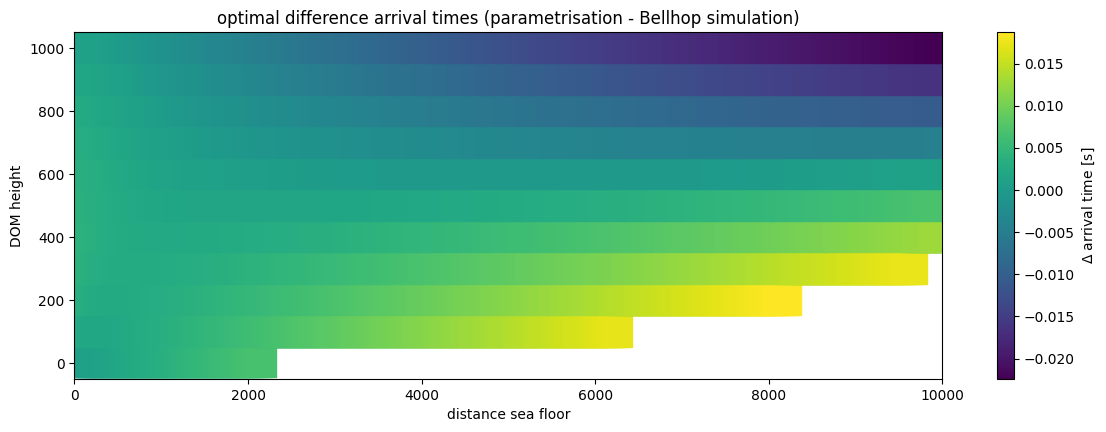

In [156]:
# Create a scatter plot with square markers
# Calculate the difference between consecutive values in x and y directions
dx = np.diff(distance_sea_floor).min()
dy = np.diff(height_DOM).min()

# Create a scatter plot with square markers
plt.figure(figsize=(14, 4.5))
plt.scatter(distance_sea_floor, height_DOM, c=delta_t, cmap='viridis', s=470, marker='s', alpha=1)#, vmin=0, vmax=max)
plt.colorbar(label='$\Delta$ arrival time [s]')
plt.xlabel('distance sea floor')
plt.ylabel('DOM height')
plt.xlim(0, 10000)
plt.ylim(-50, 1050)
plt.title('optimal difference arrival times (parametrisation - Bellhop simulation)')
#plt.gca().set_aspect('equal', adjustable='box') 

In [107]:
import numpy as np

def conductivity_to_salinity(conductivity, temperature, pressure=0):
    C_15 = 42.914  # Standard KCl solution conductivity at 15°C in mS/cm
    R = conductivity / C_15
    a = [0.0080, -0.1692, 25.3851, 14.0941, -7.0261, 2.7081]
    b = [0.0005, -0.0056, -0.0066, -0.0375, 0.0636, -0.0144]
    k = 0.0162
    sqrt_R = np.sqrt(R)
    delta_T = temperature - 15
    salinity = (a[0] + a[1]*sqrt_R + a[2]*R + a[3]*R**1.5 + a[4]*R**2 + a[5]*R**2.5) \
               + delta_T * (b[0] + b[1]*sqrt_R + b[2]*R + b[3]*R**1.5 + b[4]*R**2 + b[5]*R**2.5) \
               + k * (R**0.5 - 1)
    return salinity

# Example usage
conductivity = 46.5  # mS/cm, example conductivity value
temperature = 13.1  # °C, example temperature value
initial_salinity = conductivity_to_salinity(conductivity, temperature)
print(initial_salinity)
# Small change in conductivity
conductivity_change = conductivity + 0.03  # Adding 0.03 mS/cm
new_salinity = conductivity_to_salinity(conductivity_change, temperature)

# Sensitivity in salinity
salinity_sensitivity = new_salinity - initial_salinity
print(f"Sensitivity in Salinity: {salinity_sensitivity:.4f} PSU")


38.292015048899756
Sensitivity in Salinity: 0.0277 PSU


# Dependence Curves

In [83]:
# 1541.25 -17e-3 -2000.00

# original ssp constants
a = 1541.00
b = -17e-3
c = 2000.00
z0 = 3453.629

# calculate the sound velocity
sound_velocity = SoundVelocity(a, b, c)

dis = 800
el = 300

# redefine some parameters
z1 = z0 - el
z2 = z0 - 3

D_m = (dis**2 + (z2 - z1)**2)**(1/2)
time_0 = sound_velocity.getTime(D_m, z1, z2)

print(time_0)

0.561836031177171


In [87]:
a_s = np.linspace(-0.3, 0.3, 41)

In [88]:
# initialise an empty list to append values to
propagation_time = []
check_a = []

# loop through the values to find the propagation time
for i in range(len(a_s)):
    dis = 800
    el = 300

    # find a
    a = a_s[i] + 1541.00
    sound_velocity = SoundVelocity(a, b, c)

    # redefine some parameters
    z1 = z0 - el
    z2 = z0 - 3

    D_m = (dis**2 + (z2 - z1)**2)**(1/2)
    time = sound_velocity.getTime(D_m, z1, z2) - time_0

    propagation_time.append(time)
    check_a.append(a)

[0.00011099376864387445, 0.00010544303866522053, 9.989241834673646e-05, 9.434190768853323e-05, 8.879150667173707e-05, 8.324121529623696e-05, 7.769103356203289e-05, 7.214096146912485e-05, 6.659099901773491e-05, 6.104114618865619e-05, 5.549140300098454e-05, 4.994176943573514e-05, 4.439224549290799e-05, 3.884283117250309e-05, 3.3293526474742485e-05, 2.7744331380308296e-05, 2.219524588964461e-05, 1.6646270021292153e-05, 1.1097403737614364e-05, 5.548647076469848e-06, 0.0, -5.548537473032411e-06, -1.1096965380152923e-05, -1.6645283664962207e-05, -2.2193492383859592e-05, -2.77415915369561e-05, -3.328958108661517e-05, -3.8837461070362345e-05, -4.438523148841966e-05, -4.993289234056508e-05, -5.548044360825788e-05, -6.1027885328801545e-05, -6.657521750264017e-05, -7.212244009180413e-05, -7.766955315280377e-05, -8.321655666698735e-05, -8.876345061548108e-05, -9.431023503592151e-05, -9.985690992830865e-05, -0.0001054034752737687, -0.00011094993107241269]
[1540.7, 1540.715, 1540.73, 1540.745, 1540.

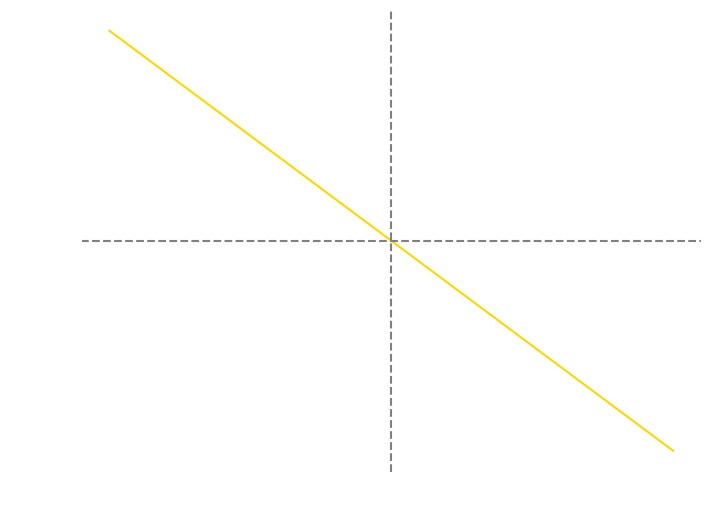

In [92]:
divided = [i/1541.00 for i in check_a]

ms = [i * 1000000 for i in propagation_time]

plt.figure(figsize=(8, 6)) 

# Stel de kleur van de assen in op wit
ax = plt.gca()  # Get current axis
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')

# Stel de kleur van de assen labels en ticks in op wit
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')


plt.plot(divided, ms, color="gold")
plt.ylabel(f"$\Delta$t [$\mu$s]")
plt.xlabel("a/a0")
plt.axvline(1, linestyle="dashed", color="gray")
plt.axhline(0, linestyle="dashed", color="gray")
print(propagation_time)
print(check_a)

plt.savefig("Changes in a.png", transparent=True)

In [93]:
# 1541.25 -17e-3 -2000.00

# original ssp constants
a = 1541.00
b = -17e-3
c = 2000.00
z0 = 3453.629

# calculate the sound velocity
sound_velocity = SoundVelocity(a, b, c)



In [94]:
b_s = np.linspace(2.5e-4, -2.5e-4, 41)
a = 1541.0
print(time_0)

0.561836031177171


In [95]:
# initialise an empty list to append values to
propagation_time_b = []
check_b = []

# loop through the values to find the propagation time
for i in range(len(b_s)):
    dis = 800
    el = 300

    # find a
    b = b_s[i] + (-17e-3) 
    sound_velocity = SoundVelocity(a, b, c)

    # redefine some parameters
    z1 = z0 - el
    z2 = z0 - 3

    D_m = (dis**2 + (z2 - z1)**2)**(1/2)
    time = sound_velocity.getTime(D_m, z1, z2) - time_0
    propagation_time_b.append(time)
    check_b.append(b)

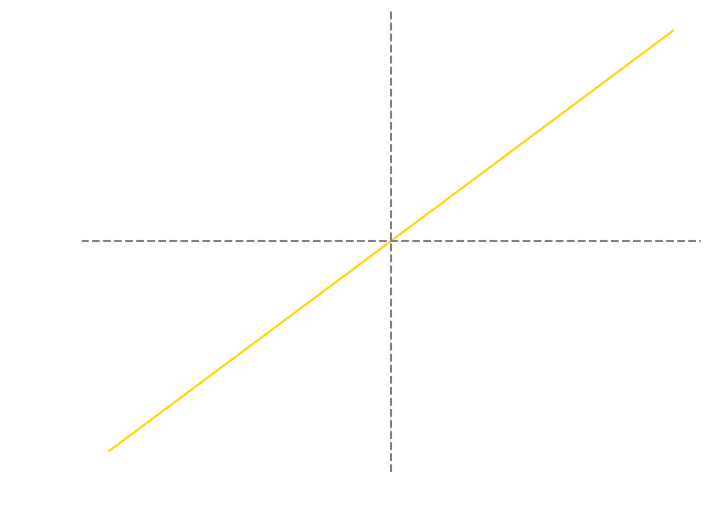

In [96]:
divided_b = [i/(-17e-3) for i in check_b]

ms_b = [i * 1000000 for i in propagation_time_b]

plt.figure(figsize=(8, 6)) 
# Stel de kleur van de assen in op wit
ax = plt.gca()  # Get current axis
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')

# Stel de kleur van de assen labels en ticks in op wit
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')


plt.plot(divided_b, ms_b, color="gold")
plt.ylabel(f"$\Delta$t [$\mu$s]")
plt.xlabel("b/b0")
plt.axvline(1, linestyle="dashed", color="gray")
plt.axhline(0, linestyle="dashed", color="gray")

plt.savefig("Changes in b.png", transparent=True)


In [172]:
# Ranges for a and b
a_s = np.linspace(-770.5, 770.5, 41) + 1541.00
b_s = np.linspace(500e-3, -500e-3, 41) + (-17e-3) 

# Create a meshgrid of a and b values
A, B = np.meshgrid(a_s, b_s)
propagation_time = np.zeros_like(A)

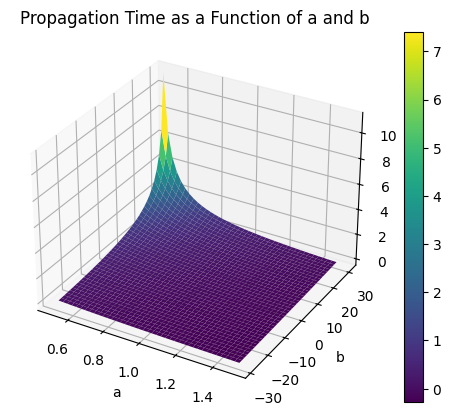

In [173]:
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        a = A[i, j]
        b = B[i, j]
        
        # Create a new SoundVelocity instance with the updated a and b
        sound_velocity = SoundVelocity(a, b, c)
        
        D_m = (dis**2 + (z2 - z1)**2)**(1/2)
        time = sound_velocity.getTime(D_m, z1, z2)
        
        propagation_time[i, j] = time - time_0

# Plotting the results
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot surface
A, B = np.meshgrid((a_s/1541), (b_s/(-17e-3)))

surf = ax.plot_surface(A, B, propagation_time, cmap='viridis')

# Add labels and title
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('Propagation Time')
ax.set_title('Propagation Time as a Function of a and b')


# Add a color bar which maps values to colors
fig.colorbar(surf)

plt.show()